<a href="https://colab.research.google.com/github/aronsalinas96/tensorflow_basics/blob/main/05_Transfer_Learning_TensorFlow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Wed Feb 16 14:13:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions


In [3]:
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Getting some data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-02-16 14:13:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.250.159.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   197MB/s    in 0.8s    

2022-02-16 14:13:24 (197 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
 for images, labels in train_data_10_percent.take(1):
   print(images, labels)

tf.Tensor(
[[[[253.        255.        250.45918  ]
   [253.        255.        250.09183  ]
   [253.        255.        250.27551  ]
   ...
   [253.        255.        252.       ]
   [253.        255.        252.       ]
   [253.        255.        252.       ]]

  [[254.        254.        254.2398   ]
   [254.        254.        253.93367  ]
   [254.        254.        254.08673  ]
   ...
   [254.        254.        252.       ]
   [254.        254.        252.       ]
   [254.        254.        252.       ]]

  [[254.        253.21428   255.       ]
   [254.        253.21428   255.       ]
   [254.        253.21428   255.       ]
   ...
   [254.        254.        254.       ]
   [254.        254.        254.       ]
   [254.        254.        254.       ]]

  ...

  [[254.14288   254.64285   250.42853  ]
   [253.85716   254.92857   250.42853  ]
   [254.00002   254.78572   250.42853  ]
   ...
   [252.83165   255.        250.       ]
   [253.08669   255.        250.       ]
   [2

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models

In [10]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False 

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25* len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent")]
)

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20220216-141334
Epoch 1/5
24/24 [==============================] - 26s 367ms/step - loss: 1.9396 - accuracy: 0.3853 - val_loss: 1.3986 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - 9s 360ms/step - loss: 1.1631 - accuracy: 0.7400 - val_loss: 0.9341 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 7s 274ms/step - loss: 0.8476 - accuracy: 0.7947 - val_loss: 0.7608 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 7s 272ms/step - loss: 0.6911 - accuracy: 0.8360 - val_loss: 0.6441 - val_accuracy: 0.8602
Epoch 5/5
24/24 [==============================] - 7s 274ms/step - loss: 0.5959 - accuracy: 0.8600 - val_loss: 0.6001 - val_accuracy: 0.8569


In [11]:
model_0.evaluate(test_data)

79/79 [==============================] - 12s 141ms/step - loss: 0.6119 - accuracy: 0.8440


[0.6119014024734497, 0.843999981880188]

In [12]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2d layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [15]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"{input_tensor}\n")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooling random tensor:\n {global_average_pooled_tensor}")

[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Average Pooling random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]


In [16]:
# Replicating the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a  series of transfer learning experiments

Let's try differents experiments:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` use fine-tuning transfer learning with 10% of the training data with data augmentation
4. `model_4` use fine-tuning transfer learning with 100% of the training data with data augmentation

In [17]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-02-16 14:14:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  83.0MB/s    in 1.5s    

2022-02-16 14:14:56 (83.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [18]:
train_dir_1_percent = "10_food_classes_1_percent/train/"

test_dir_1_percent = "10_food_classes_1_percent/test/"

In [19]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [20]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE
                                                                )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images happens on the GPU rather than the CPU, which is faster.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [21]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      #preprocessing.Rescale(1./255) For Resnet50V2
], name="data_augmentation")

## Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 511.5, 381.5, -0.5)

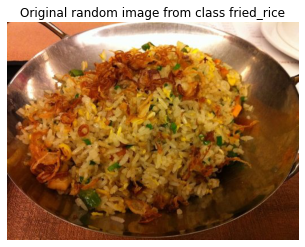

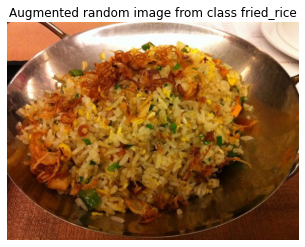

In [22]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os 
import random 

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [23]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220216-141502
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.4019 - accuracy: 0.1143 - val_loss: 2.2173 - val_accuracy: 0.1678
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1424 - accuracy: 0.2571 - val_loss: 2.1073 - val_accuracy: 0.2220
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9585 - accuracy: 0.4286 - val_loss: 1.9979 - val_accuracy: 0.3224
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.7451 - accuracy: 0.5714 - val_loss: 1.8795 - val_accuracy: 0.3997
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6940 - accuracy: 0.6714 - val_loss: 1.8111 - val_accuracy: 0.4605


In [24]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [25]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 134ms/step - loss: 1.8091 - accuracy: 0.4528


[1.8091039657592773, 0.4528000056743622]

## Model 2: feature etraction transfer learning with 10% of data and data augmentation

In [26]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-02-16 14:16:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   210MB/s    in 0.8s    

2022-02-16 14:16:03 (210 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [27]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir =  "10_food_classes_10_percent/test/"

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = image_dataset_from_directory(train_dir_10_percent, 
                                                     label_mode="categorical",
                                                     image_size=IMG_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2)
], name ="data_augmentation")

input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

## Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is usefeul to come and start where we left off.

In [30]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [31]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220216-141608
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0105 - accuracy: 0.3227
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 736ms/step - loss: 2.0105 - accuracy: 0.3227 - val_loss: 1.5212 - val_accuracy: 0.6299
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3734 - accuracy: 0.6933
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 680ms/step - loss: 1.3734 - accuracy: 0.6933 - val_loss: 1.0950 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.7480
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 687ms/step - loss: 1.0675 - accuracy: 0.7480 - val_loss: 0.9001 - val_accuracy: 0.7615
E

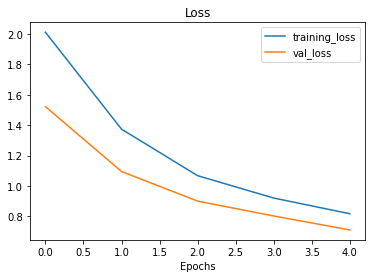

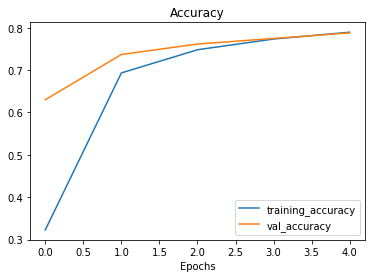

In [32]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [33]:
model_2.load_weights(checkpoint_path)

In [34]:
loaded_weights_model_resutls = model_2.evaluate(test_data)

79/79 [==============================] - 11s 136ms/step - loss: 0.7060 - accuracy: 0.8084


In [35]:
loaded_weights_model_resutls

[0.7059832811355591, 0.8083999752998352]

## Model 3: Fine-tuning an existing model on 10% of the data

In [36]:
model_2.layers

In [37]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f70522daa50> True
<keras.engine.sequential.Sequential object at 0x7f6fe17c7950> True
<keras.engine.functional.Functional object at 0x7f6fe1386750> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f6fe14bafd0> True
<keras.layers.core.dense.Dense object at 0x7f6fe1361ed0> True


In [38]:
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"]) # when fine-tuning you tipically want to reduce learning rate by 10x*


**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x. A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [39]:
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 with more trainable layers )
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")]) # start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220216-141810
Epoch 5/10
24/24 [==============================] - 28s 760ms/step - loss: 0.6933 - accuracy: 0.8027 - val_loss: 0.5874 - val_accuracy: 0.7993
Epoch 6/10
24/24 [==============================] - 12s 501ms/step - loss: 0.5557 - accuracy: 0.8320 - val_loss: 0.5280 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 13s 521ms/step - loss: 0.4952 - accuracy: 0.8467 - val_loss: 0.5332 - val_accuracy: 0.8174
Epoch 8/10
24/24 [==============================] - 14s 558ms/step - loss: 0.4681 - accuracy: 0.8533 - val_loss: 0.5456 - val_accuracy: 0.7961
Epoch 9/10
24/24 [==============================] - 15s 599ms/step - loss: 0.4060 - accuracy: 0.8787 - val_loss: 0.4956 - val_accuracy: 0.8191
Epoch 10/10
24/24 [==============================] - 14s 573ms/step - loss: 0.3795 - accuracy: 0.8733 - val_loss: 0.4886 - val_accuracy: 0.8240


In [40]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 0.4954 - accuracy: 0.8312


In [41]:
results_fine_tune_10_percent

[0.49542075395584106, 0.8312000036239624]

The ``plot_loss_curves` function works great with modfels which have only been fit once, however, we want of running `fit()` with another (e.g before and after fine-tuning).

In [42]:
def compare_historys(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Validation accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Star Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Validation loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Star Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

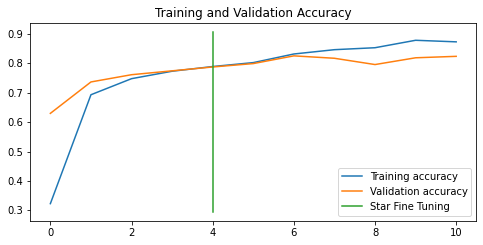

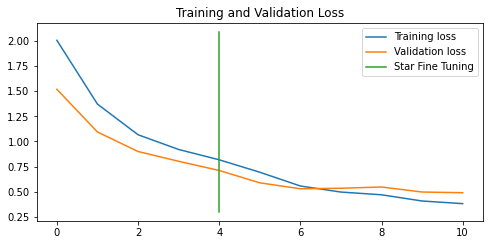

In [43]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine tuning and existing model on ALL of the data

In [44]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-02-16 14:20:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   204MB/s    in 2.4s    

2022-02-16 14:20:20 (204 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [45]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [46]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [47]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments

In [48]:
model_2.load_weights(checkpoint_path)

In [49]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [50]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [51]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [52]:
fine_tune_epochs = initial_epochs + 5 
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220216-142030
Epoch 5/10
235/235 [==============================] - 99s 383ms/step - loss: 0.7284 - accuracy: 0.7632 - val_loss: 0.4197 - val_accuracy: 0.8602
Epoch 6/10
235/235 [==============================] - 77s 325ms/step - loss: 0.5978 - accuracy: 0.8084 - val_loss: 0.3986 - val_accuracy: 0.8635
Epoch 7/10
235/235 [==============================] - 73s 309ms/step - loss: 0.5241 - accuracy: 0.8317 - val_loss: 0.3895 - val_accuracy: 0.8668
Epoch 8/10
235/235 [==============================] - 67s 284ms/step - loss: 0.4939 - accuracy: 0.8431 - val_loss: 0.3442 - val_accuracy: 0.8717
Epoch 9/10
235/235 [==============================] - 63s 264ms/step - loss: 0.4551 - accuracy: 0.8544 - val_loss: 0.3300 - val_accuracy: 0.8997
Epoch 10/10
235/235 [==============================] - 61s 258ms/step - loss: 0.4190 - accuracy: 0.8665 - val_loss: 0.3462 - val_accuracy: 0.8750


In [54]:
model_2.evaluate(test_data)

79/79 [==============================] - 13s 148ms/step - loss: 0.3134 - accuracy: 0.8972


[0.3134310841560364, 0.8971999883651733]

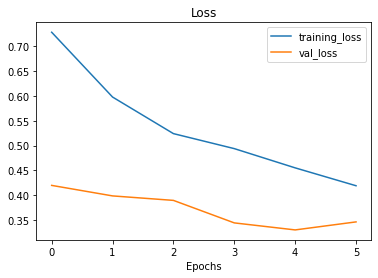

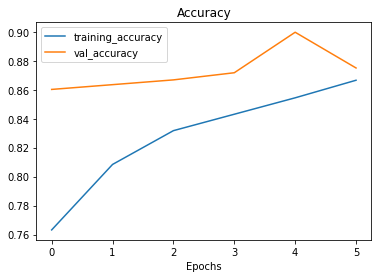

In [53]:
plot_loss_curves(history_fine_10_classes_full)

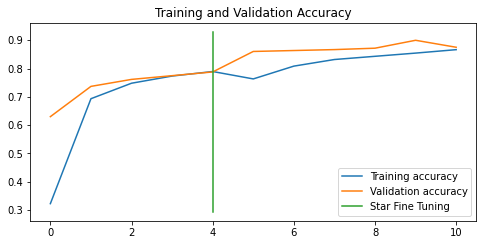

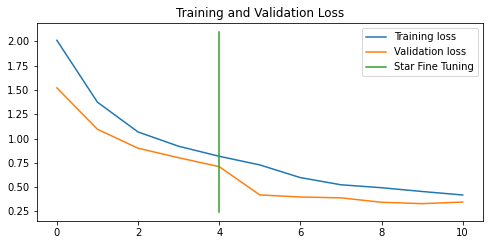

In [56]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing experiments data on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments with 10 Food101 Classes" \
  --description "Experiments with different data and models" \
  --one_shot

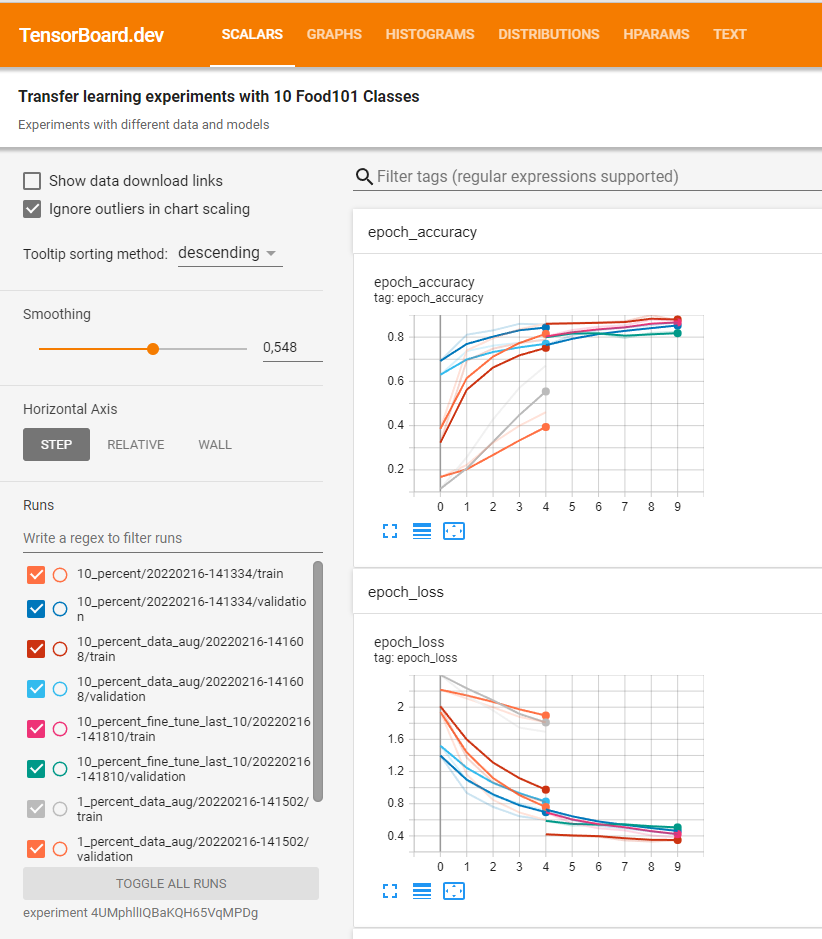